In [1]:
import os
import json
import re
from time import time
from itertools import product

import numpy as np
import torch
from torch import optim
from torch import nn
from torch.autograd import Variable
from torch.nn import Softmax
import matplotlib.pyplot as plt
%matplotlib inline

from datautils.dataset import Alphabet, to_categorical, SentenceDataset, to_categorical, TextFile
from models.utils import RNN_Hyperparameters
from models.rnn import get_rnn_for_hyperparams

from training import evaluate_rnn, evaluate_rnn_sentences

In [2]:
# %%time
use_gpu = True

exp_dir = '../rnn-experiment-storage/22_en_60_b250_lstm_1024/'
# spec_name = "00_test"

# # Load spec
# with open(os.path.join(exp_dir, 'train_hidden', f'{spec_name}.json')) as fp:
#     spec = json.load(fp)

spec = {
  "model_id": 0,
  "train_files_list": [
    "datasets/es-en/en/train.txt"
  ],
  "max_train_chars": 2000000,
  "valid_files_list": [
    "datasets/es-en/en/valid.txt"
  ],
  "max_valid_chars": 50000,
  "batch_sizes": [
    50
  ],
  "num_timesteps_vals": [
    10
  ],
  "lrs": [
    -1
  ],
  "epochs": 5
}
    
model_id = str(spec['model_id'])

train_files_list = spec['train_files_list']
valid_files_list = spec['valid_files_list']
if 'max_train_chars' in spec:
    max_train_chars = int(spec['max_train_chars'])
else:
    max_train_chars = np.inf
if 'max_valid_chars' in spec:
    max_valid_chars = int(spec['max_valid_chars'])
else:
    max_valid_chars = np.inf

batch_sizes = spec['batch_sizes']
num_timesteps_vals = spec['num_timesteps_vals']
lrs = spec['lrs']
epochs = spec['epochs']
patience = 3


hidden_states_folder = os.path.join(exp_dir, 'out', model_id, 'init_hiddens')
if not os.path.exists(hidden_states_folder):
    os.makedirs(hidden_states_folder)

alphabet = Alphabet.from_json(os.path.join(exp_dir, 'alphabet.json'))

results_file = os.path.join(exp_dir, 'out/results.json')
with open(results_file, 'r') as fp:
    exp_results = json.load(fp)

hyperparams = RNN_Hyperparameters(**exp_results[str(model_id)]['config'])

model = get_rnn_for_hyperparams(hyperparams, alphabet.get_size(), use_gpu)

checkpoint_path = exp_results[str(model_id)]['path']

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

if use_gpu:
    model.cuda()

pad_input = True

results = []

configs = list(product(batch_sizes, num_timesteps_vals, lrs))
for i, (batch_size, num_timesteps, lr) in enumerate(configs):
    
    run_res_dict = {
        'batch_size': batch_size,
        'num_timesteps': num_timesteps,
        'lr': lr,
        'epochs': epochs
    }
    print(f'Starting training for configuration {i+1}|{len(configs)}:\n{json.dumps(run_res_dict,indent=2)}\n')
    
    torch.manual_seed(2019)
    np.random.seed(2019)
    
    # Define hidden state variables to be trained
    if use_gpu:
        initial_hidden = (Variable(torch.zeros(model.num_layers, batch_size, model.hidden_dim).cuda(), requires_grad=True),
                      Variable(torch.zeros(model.num_layers, batch_size, model.hidden_dim).cuda(), requires_grad=True))
    else:
        initial_hidden = (Variable(torch.zeros(model.num_layers, batch_size, model.hidden_dim), requires_grad=True),
                          Variable(torch.zeros(model.num_layers, batch_size, model.hidden_dim), requires_grad=True))

    if lr > 0:
        optimizer = torch.optim.SGD(initial_hidden, lr=lr)
    else:
        optimizer = torch.optim.Adam(initial_hidden)

    loss_function = nn.modules.loss.CrossEntropyLoss()

    train_data = SentenceDataset(train_files_list, alphabet)
    valid_data = SentenceDataset(valid_files_list, alphabet)

    best_initial_hidden_state = None

    hiddens = [[initial_hidden[0].cpu().data.numpy()],[initial_hidden[1].cpu().data.numpy()]]
    train_losses = []
    valid_losses = []
    val_loss_histories = []

    min_val_loss = np.inf
    # Record final validation loss
    val_loss, run_history = evaluate_rnn_sentences(model, valid_data, initial_hidden, batch_size, num_timesteps,
                                                   pad_input, loss_function, use_gpu, max_chars=max_valid_chars)
    valid_losses.append(val_loss)
    val_loss_histories.append(run_history)
    print(f'Initial Validation Loss: {val_loss:.3f}')
    min_val_loss = val_loss
    best_initial_hidden_state = (model.hidden[0].data.cpu().numpy(), model.hidden[1].data.cpu().numpy())
    
    for epoch_ix in range(epochs):
        start = time()
        print(f'Starting epoch {epoch_ix + 1}|{epochs}')

        for inputs, targets in train_data.get_batch_iterator(batch_size, num_timesteps, pad_input=pad_input,
                                                             max_chars_per_file=max_train_chars):
            model.hidden = initial_hidden

            if use_gpu:
                inputs = Variable(torch.Tensor(inputs)).cuda()
                targets = Variable(torch.LongTensor(targets)).cuda()
            else:
                inputs = Variable(torch.Tensor(inputs))
                targets = Variable(torch.LongTensor(targets))
            
           
            # Reset the gradiens in prep for a new step
            model.zero_grad()
            optimizer.zero_grad()

            # Forward pass through a batch of sequences - the result is <batch_size x num_timesteps x alphabet_size> -
            # the outputs for each sequence in the batch, at every timestep in the sequence
            logits = model(inputs)
            loss = loss_function(logits.contiguous().view(-1, logits.data.shape[-1]), targets.contiguous().view(-1))
            train_losses.append(loss.data.cpu().numpy()[0])

            # Backward pass - compute gradients, propagate gradient information back through the network
            loss.backward()

            # Update hidden state
            optimizer.step()

            hiddens[0].append(initial_hidden[0].cpu().data.numpy())
            hiddens[1].append(initial_hidden[1].cpu().data.numpy())
        
        print(f'Finished epoch {epoch_ix + 1}|{epochs} in {(time() - start):2f} seconds')
    
        val_loss, run_history = evaluate_rnn_sentences(model, valid_data, initial_hidden, batch_size, num_timesteps,
                                                   pad_input, loss_function, use_gpu, max_chars=max_valid_chars)
        valid_losses.append(val_loss)
        val_loss_histories.append(run_history)
        print(f'Validation Loss: {val_loss:.3f}')
        print('-'*10)
        # Early stopping:
        if (len(valid_losses) > patience) and np.all([(valid_losses[-i-2] <= valid_losses[-i-1] + 1e-3) for i in range(patience)]):

            print(f'STOPPING: Validation loss has not improved in {patience} epochs')
            break
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_initial_hidden_state = (initial_hidden[0].data.cpu().numpy().mean(1),
                                         initial_hidden[1].data.cpu().numpy().mean(1))
        
    run_res_dict['valid_losses'] = valid_losses
    run_res_dict['train_losses'] = train_losses
    run_res_dict['best_state'] = best_initial_hidden_state
    run_res_dict['best_val_loss'] = min_val_loss

    results.append(run_res_dict)
    print('=' * 20)


# Save results
for res in results:
    conf_id = str(len(os.listdir(hidden_states_folder)))
    conf_dir = os.path.join(hidden_states_folder, conf_id)
    os.makedirs(conf_dir)
    
    np.save(os.path.join(conf_dir, 'h.npy'), res['best_state'][0])
    np.save(os.path.join(conf_dir, 'c.npy'), res['best_state'][1])
    del(res['best_state'])
    
    res['train_files_list'] = train_files_list
    res['valid_files_list'] = valid_files_list
    res['train_losses'] = [float(x) for x in res['train_losses']]
    res['valid_losses'] = [float(x) for x in res['valid_losses']]

    with open(os.path.join(conf_dir, 'stats.json'), 'w+') as fp:
        json.dump(res, fp, indent=2)   

Starting training for configuration 1|1:
{
  "batch_size": 50,
  "num_timesteps": 10,
  "lr": -1,
  "epochs": 5
}

Initial Validation Loss: 3.102
Starting epoch 1|5
Finished epoch 1|5 in 13.344327 seconds
Validation Loss: 1.616
----------
Starting epoch 2|5
Finished epoch 2|5 in 15.609171 seconds
Validation Loss: 1.591
----------
Starting epoch 3|5
Finished epoch 3|5 in 13.744497 seconds
Validation Loss: 1.588
----------
Starting epoch 4|5
Finished epoch 4|5 in 14.953396 seconds
Validation Loss: 1.588
----------
Starting epoch 5|5
Finished epoch 5|5 in 15.820031 seconds
Validation Loss: 1.588
----------


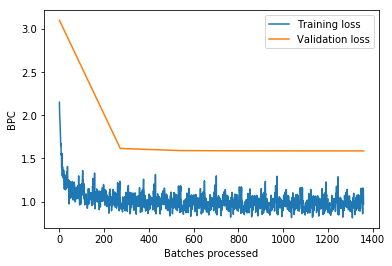

In [3]:

plt.plot(results[0]['train_losses'], label='Training loss')
plt.plot(np.arange(len(valid_losses)) * len(results[0]['train_losses']) / (len(results[0]['valid_losses']) - 1),
                           results[0]['valid_losses'], label='Validation loss');
plt.legend();
plt.ylabel('BPC')
plt.xlabel('Batches processed');

# Get unigram distribution of starting characters

In [265]:
from collections import Counter
c = Counter()
for inputs, targets in train_data.get_batch_iterator(batch_size=1, num_timesteps=num_timesteps):
    c.update(inputs.argmax(2)[:, 0])

    
tot_chars = sum(c.values())
start_chars_probs = [(i, (c[i] / tot_chars)) for i in sorted(c)]

alphabet.ids_to_string([x[0] for x in c.most_common()])

'TIWMAFOSHBNLCEP.YD(RU�GQJ-VtaK\'io2w,"1db‘fs3cZperhmv4n[?l59u78y)6g0jX*“:k/x'

# Get predictions for first character

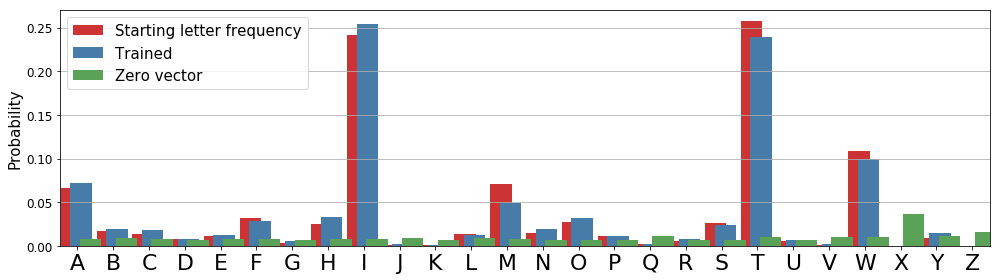

In [268]:
import pandas as pd
import seaborn as sns

inp_pad = Variable(torch.Tensor(to_categorical([0], alphabet.get_size())).view(1, 1, -1))
inp_dot_space = Variable(torch.Tensor(to_categorical(alphabet.string_to_ids('.\n'), alphabet.get_size())).view(1, 2, -1))

init_hid = (Variable(torch.Tensor(best_initial_hidden_state[0]).view(1,1,-1)),
            Variable(torch.Tensor(best_initial_hidden_state[1]).view(1,1,-1)))
if use_gpu:
    init_hid = (init_hid[0].cuda(), init_hid[1].cuda())
    inp_pad = inp_pad.cuda()
    inp_dot_space = inp_dot_space.cuda()

model.hidden = init_hid
# model.hidden = (initial_hidden[0].mean(1).view(1,1,-1), initial_hidden[1].mean(1).view(1,1,-1))

logits = model.forward(inp_pad)
sm = nn.Softmax(dim=2)
preds = sm(logits)
preds = preds.data.cpu().numpy()[0]
pred = preds[0]

# Zero hidden
zero_hidden = model.init_hidden(batch_size=1)
zero_logits = model.hidden2out(zero_hidden[0])
zero_pred = sm(zero_logits).data.cpu().numpy()[0][0]

# Zero hidden plus dot space
model.hidden = zero_hidden
zds_logits = model.forward(inp_dot_space)
zds_pred = sm(zds_logits).data.cpu().numpy()[0][0]


df = pd.DataFrame(columns=['char_id', 'pred', 'type'])
df.char_id = np.arange(len(pred))
df1 = df.copy(deep=True)
df2 = df.copy(deep=True)
df2.pred = zero_pred
df2.type = 'Zero vector'
df3 = df.copy(deep=True)
df3.pred = zds_pred
df3.type = 'Zero vector + <dot><space>'
df.pred = pred
df.type = 'Trained'
df1.pred = 0
df1.type = 'Starting letter frequency'
for cid, p in start_chars_probs:
    df1.loc[(df.char_id == cid), 'pred'] = p
df = df1.append(df)
df = df.append(df2)
# df = df.append(df3)
df.rename(columns={'type':'Hidden type'})

rng_min, rng_max = alphabet.char_to_int['A'], alphabet.char_to_int['Z']
# rng_min, rng_max = 0, alphabet.get_size()-1
dfp = df[(df.char_id <= rng_max) & (df.char_id >= rng_min)]
fig, ax = plt.subplots(1,1, figsize=(14,4))
sns.barplot(x='char_id', y='pred', hue='type', data=dfp, ax=ax, palette='Set1')
# ax.set_xticks(np.arange(rng_max - rng_min))
ax.set_xticklabels([alphabet.int_to_char[x] for x in range(rng_min, rng_max+1)], fontsize=22);
plt.grid(axis='y')
plt.legend(fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xlabel('');
plt.yticks(fontsize=12)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .2)
change_width(ax, 0.6)
plt.tight_layout()
# plt.savefig('../rnn-experiment-storage/plots/22_init_train_10_first_letter_whole.pdf')
plt.savefig('../rnn-experiment-storage/plots/22_init_train_10_first_letter.pdf')

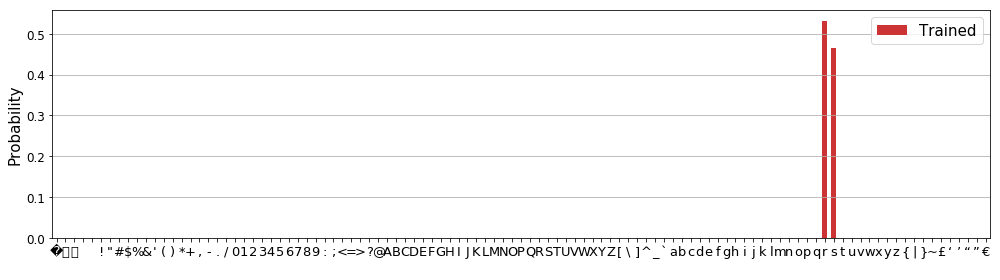

In [88]:
import pandas as pd
import seaborn as sns

inp = 'Below is the issues & to do list as we go forward with documenting the requir'
inp_pad = Variable(torch.Tensor(to_categorical([0] + alphabet.string_to_ids(inp), alphabet.get_size())).view(
    1, len(inp) + 1, -1))

init_hid = (Variable(torch.Tensor(best_initial_hidden_state[0]).view(1,1,-1)),
            Variable(torch.Tensor(best_initial_hidden_state[1]).view(1,1,-1)))
if use_gpu:
    init_hid = (init_hid[0].cuda(), init_hid[1].cuda())
    inp_pad = inp_pad.cuda()

model.hidden = init_hid
model.hidden = model.init_hidden(batch_size=1)

logits = model.forward(inp_pad)
logits = model.hidden2out(model.hidden[0])
sm = nn.Softmax(dim=2)
preds = sm(logits)
preds = preds.data.cpu().numpy()[0]
pred = preds[-1]

df = pd.DataFrame(columns=['char_id', 'pred', 'type'])
df.char_id = np.arange(len(pred))
df.pred = pred
df.type = 'Trained'
df.rename(columns={'type':'Hidden type'})

# rng_min, rng_max = alphabet.char_to_int['A'], alphabet.char_to_int['Z']
rng_min, rng_max = 0, alphabet.get_size()-1
dfp = df[(df.char_id <= rng_max) & (df.char_id >= rng_min)]
fig, ax = plt.subplots(1,1, figsize=(14,4))
sns.barplot(x='char_id', y='pred', hue='type', data=dfp, ax=ax, palette='Set1')
# ax.set_xticks(np.arange(rng_max - rng_min))
ax.set_xticklabels([alphabet.int_to_char[x] for x in range(rng_min, rng_max+1)], fontsize=13);
plt.grid(axis='y')
plt.legend(fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xlabel('');
plt.yticks(fontsize=12)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .2)
change_width(ax, 0.6)
plt.tight_layout()
# plt.savefig('../rnn-experiment-storage/plots/22_init_train_10_first_letter_whole.pdf')
# plt.savefig('../rnn-experiment-storage/plots/22_init_train_10_first_letter.pdf')

# Record losses

In [226]:
%%time
LOG_2E = np.log2(np.e)
eval_seq_length = 100
eval_files = ["datasets/es-en/en/valid.txt"]
max_eval_chars = 100000

eval_data = SentenceDataset(eval_files, alphabet)

res = []

for use_trained in True, False:
    loss_function = nn.CrossEntropyLoss(reduce=False)

    if use_trained:
        init_hid = (Variable(torch.Tensor(best_initial_hidden_state[0]).view(1,1,-1)),
                    Variable(torch.Tensor(best_initial_hidden_state[1]).view(1,1,-1)))
    else:
        init_hid = model.init_hidden(batch_size=1)


    losses = []
    for inputs, targets in eval_data.get_batch_iterator(1, eval_seq_length, max_chars_per_file=max_eval_chars,
                                                        pad_input=True):

        if use_trained:
            init_hid = (Variable(torch.Tensor(best_initial_hidden_state[0]).view(1,1,-1)),
                        Variable(torch.Tensor(best_initial_hidden_state[1]).view(1,1,-1)))
        else:
            init_hid = model.init_hidden(batch_size=1)
        if use_gpu:
            init_hid = (init_hid[0].cuda(), init_hid[0].cuda())
            
        model.hidden = init_hid
        if use_gpu:
            inputs = Variable(torch.Tensor(inputs)).cuda()
            targets = Variable(torch.LongTensor(targets)).cuda()
        else:
            inputs = Variable(torch.Tensor(inputs))
            targets = Variable(torch.LongTensor(targets))

        logits = model(inputs)

        loss = loss_function(logits.contiguous().view(-1, logits.data.shape[-1]), targets.contiguous().view(-1))
        losses.append(LOG_2E * loss.data.cpu().numpy())
    
    res.append({'trained_init': use_trained, 'losses': np.array(losses)})
    

Wall time: 1min 26s


C:\Users\Yasen\Miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\Users\Yasen\Miniconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


701 1.5282439
701 0.0
701 1.6933303
701 0.0
701 1.6933303


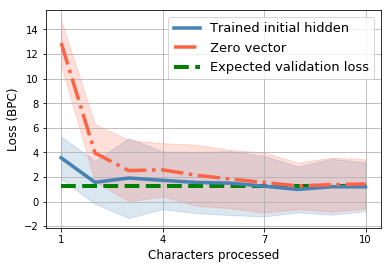

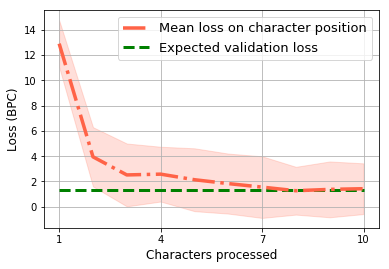

In [244]:
mss = []

for r, c, ls in zip(res, ['steelblue', 'tomato'], ['-', '-.']):
    mean_losses = r['losses'].mean(0)
    ms = [mean_losses[:i].mean() for i in range(len(mean_losses))]
    mss.append(ms)
    print(len(r['losses']), mean_losses.mean())
    print(len(r['losses']), mean_losses[:1].std() / np.sqrt(len(r['losses'])))

    loss_std = r['losses'].std(0)
    label = 'Trained initial hidden' if r['trained_init'] else 'Zero vector'
    n = 10
    plt.plot(mean_losses[:n], color=c, label=label, ls=ls, lw=3.5);
    plt.fill_between(np.arange(n), mean_losses[:n] - loss_std[:n], mean_losses[:n] + loss_std[:n], color=c, alpha=0.2)

plt.hlines(exp_loss, 0, n-1, lw=4, color='g', linestyle='--', label='Expected validation loss')
plt.grid()
plt.xticks(list(range(0, n, 3)), list(range(1, n + 1, 3)))
plt.legend(fontsize=13);
plt.xlabel('Characters processed', fontsize=12)
plt.ylabel('Loss (BPC)', fontsize=12);
plt.savefig('../rnn-experiment-storage/plots/22_good_hid_state_comp.pdf')

plt.figure()
exp_loss = 1.3
for r, c, ls in zip(res, ['steelblue', 'tomato'], ['-', '-.']):
    if r['trained_init']: continue
    mean_losses = r['losses'].mean(0)
    print(len(r['losses']), mean_losses.mean())
    loss_std = r['losses'].std(0)
    n = 10
    plt.plot(mean_losses[:n], color=c, ls=ls, lw=3.5, label='Mean loss on character position');
    plt.hlines(exp_loss, 0, n-1, lw=3, color='g', linestyle='--', label='Expected validation loss')
    plt.fill_between(np.arange(n), mean_losses[:n] - loss_std[:n], mean_losses[:n] + loss_std[:n], color=c, alpha=0.2)

plt.grid()
plt.xticks(list(range(0, n, 3)), list(range(1, n + 1, 3)))
plt.legend(fontsize=13);
plt.xlabel('Characters processed', fontsize=12)
plt.ylabel('Loss (BPC)', fontsize=12);
plt.savefig('../rnn-experiment-storage/plots/22_init_loss.pdf')


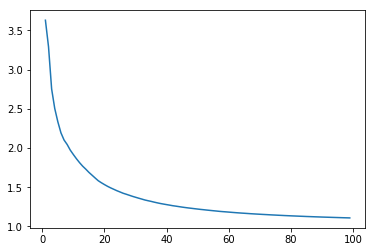

In [237]:
imps = [o / n for n, o in zip(mss[0], mss[1])]
plt.plot(imps)

In [240]:
for i in [1, 5, 10, 20, 99]:
    print(i, mss[0][i], mss[1][i], imps[i])

1 3.5522106 12.897068 3.630716
5 2.0627217 4.816957 2.3352432
10 1.6453915 3.1547463 1.9173226
20 1.5030282 2.3064592 1.5345416
99 1.5284997 1.695254 1.1090966


TIWAMFSHCOBNDPER-tLY(UG.VJoe iarQK3,
w2')cmlb5fny1Zd94"�76qsXhjug8?[v+0/k%p:];!zx£$=&\@`|‘’*~{	“”>€}<#_^


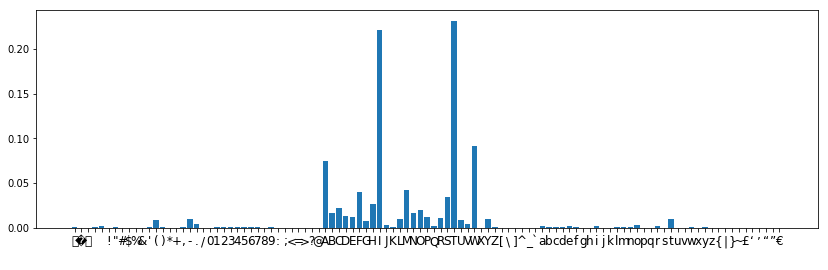

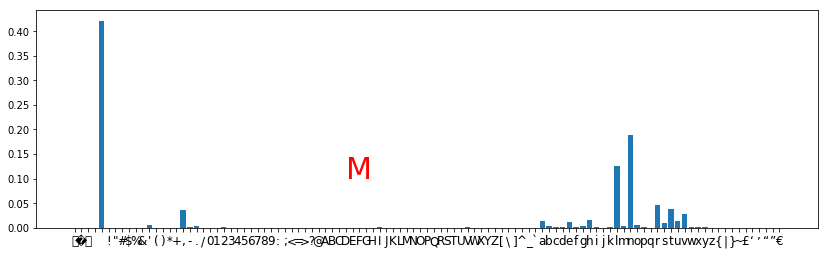

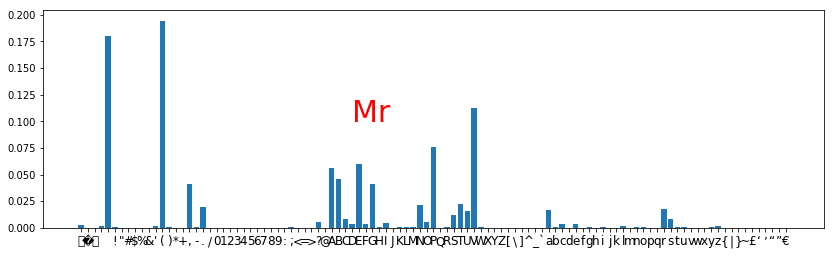

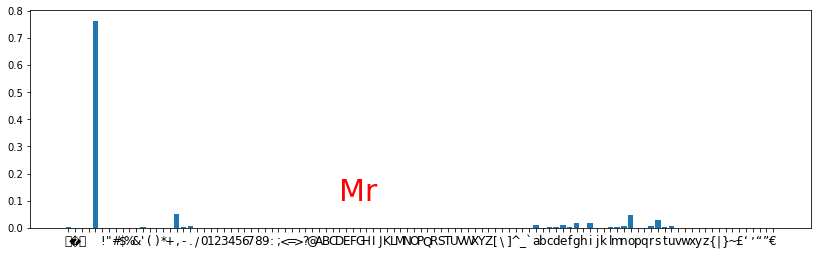

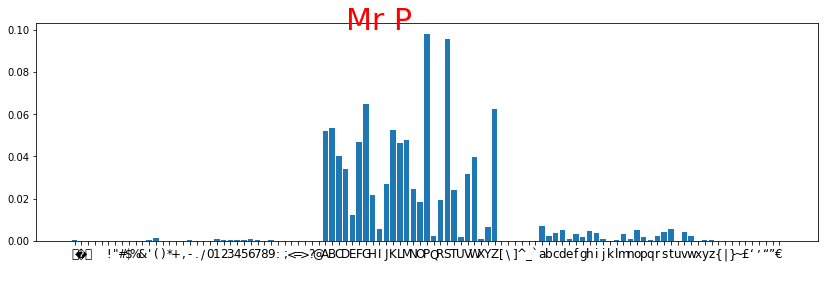

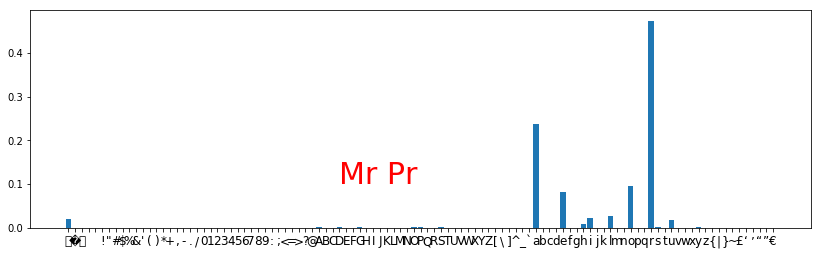

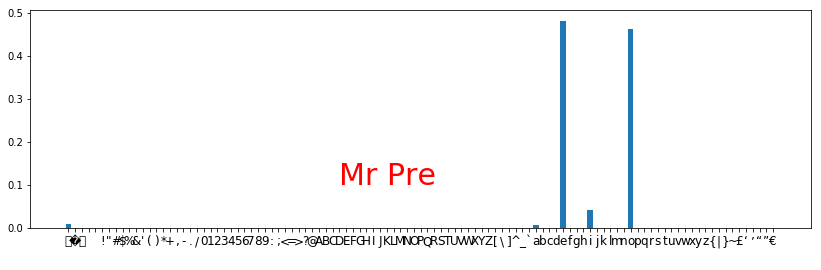

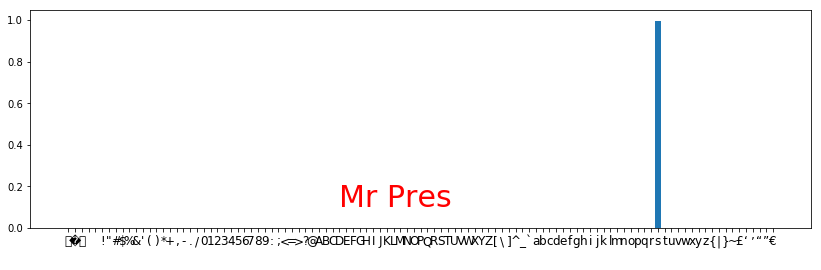

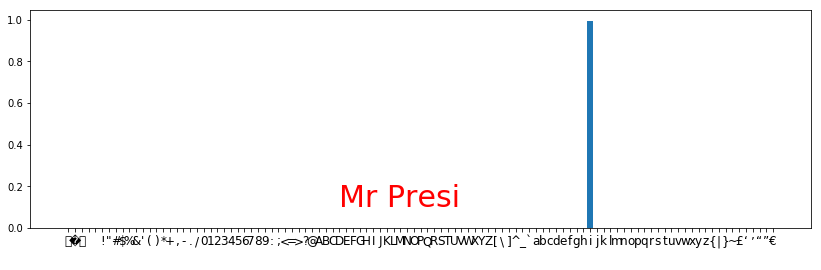

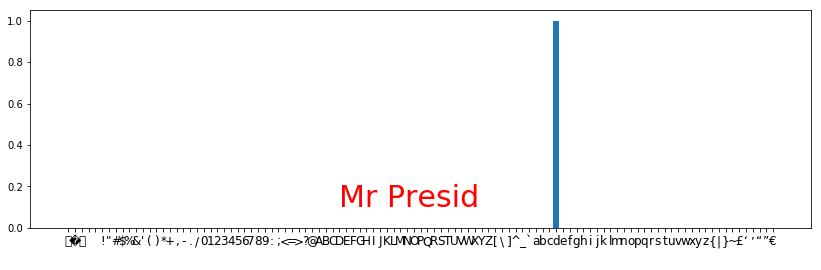

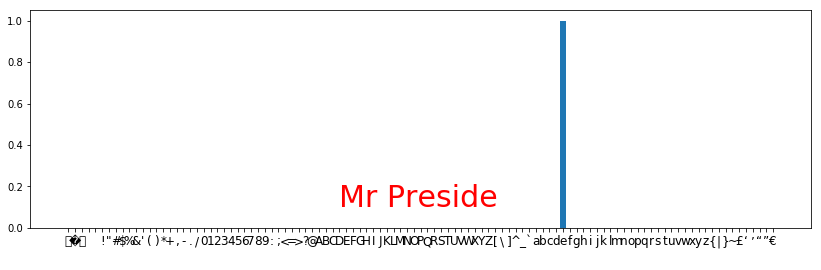

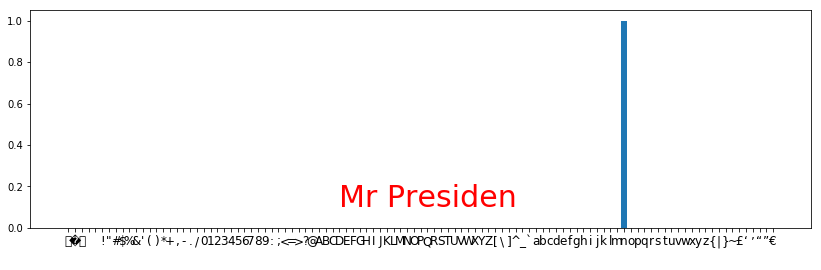

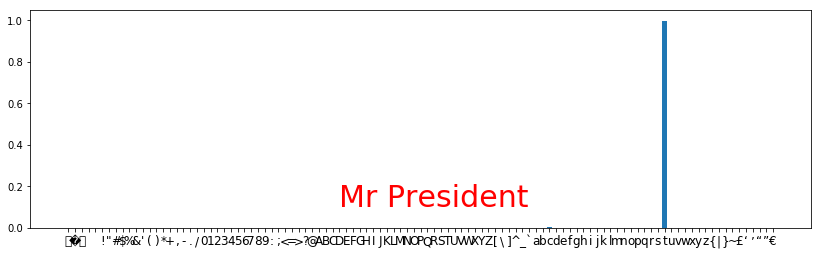

In [63]:
init_str = 'Mr President'
inp_pad = Variable(torch.Tensor(to_categorical([0] + alphabet.string_to_ids(init_str),
                                               alphabet.get_size())).view(1, 1 + len(init_str), -1))

init_hid = (Variable(torch.Tensor(best_initial_hidden_state[0]).view(1,1,-1)),
            Variable(torch.Tensor(best_initial_hidden_state[1]).view(1,1,-1)))

if use_gpu:
    init_hid = (init_hid[0].cuda(), init_hid[0].cuda())
    inp_pad = inp_pad.cuda()

# model.hidden = (initial_hidden[0].mean(1).view(1,1,-1), initial_hidden[1].mean(1).view(1,1,-1))
# model.hidden = model.init_hidden(batch_size=1)

model.hidden = init_hid

logits = model.forward(inp_pad)
sm = nn.Softmax(dim=2)
pred = sm(logits)
# pred = sm(model.hidden2out(model.hidden[0])).data.cpu().numpy().reshape(-1)

preds = pred.data.cpu().numpy()[0]
most_prob = preds[0].argsort()[::-1]

print(alphabet.ids_to_string(most_prob))

for i, pred in enumerate(preds):
    fig, ax = plt.subplots(1,1, figsize=(14,4))
    ax.bar(np.arange(len(pred)), pred)
    ax.set_xticks(np.arange(len(pred)))
    ax.set_xticklabels(alphabet.int_to_char.values(), fontsize=12)
    ax.text(40, 0.1, init_str[:i], fontsize=30, color='r')